In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airbnb-listings-reviews/Airbnb Data/Listings.csv
/kaggle/input/airbnb-listings-reviews/Airbnb Data/Reviews.csv
/kaggle/input/airbnb-listings-reviews/Airbnb Data/Reviews_data_dictionary.csv
/kaggle/input/airbnb-listings-reviews/Airbnb Data/Listings_data_dictionary.csv


In [33]:
df = pd.read_csv('/kaggle/input/airbnb-listings-reviews/Airbnb Data/Listings.csv', encoding='unicode_escape', low_memory=False)


**Exploring Data**

In [34]:
df.head()


listing_id                                              name   host_id  \
0      281420    Beautiful Flat in le Village Montmartre, Paris   1466919   
1     3705183                   39 mÃÂ² Paris (Sacre CÃ
âur)  10328771   
2     4082273               Lovely apartment with Terrace, 60m2  19252768   
3     4797344               Cosy studio (close to Eiffel tower)  10668311   
4     4823489  Close to Eiffel Tower - Beautiful flat : 2 rooms  24837558   

   host_since                 host_location host_response_time  \
0  2011-12-03  Paris, Ile-de-France, France                NaN   
1  2013-11-29  Paris, Ile-de-France, France                NaN   
2  2014-07-31  Paris, Ile-de-France, France                NaN   
3  2013-12-17  Paris, Ile-de-France, France                NaN   
4  2014-12-14  Paris, Ile-de-France, France                NaN   

   host_response_rate  host_acceptance_rate host_is_superhost  \
0                 NaN                   NaN                 f   
1                 NaN                   NaN                 f   
2                 NaN                   NaN                 f   
3                 NaN                   NaN                 f   
4                 NaN                   NaN                 f   

   host_total_listings_count  ... minimum_nights maximum_nights  \
0                        1.0  ...              2           1125   
1                        1.0  ...              2           1125   
2                        1.0  ...              2           1125   
3                        1.0  ...              2           1125   
4                        1.0  ...              2           1125   

  review_scores_rating review_scores_accuracy review_scores_cleanliness  \
0                100.0                   10.0                      10.0   
1                100.0                   10.0                      10.0   
2                100.0                   10.0                      10.0   
3                100.0                   10.0                      10.0   
4                100.0                   10.0                      10.0   

   review_scores_checkin  review_scores_communication review_scores_location  \
0                   10.0                         10.0                   10.0   
1                   10.0                         10.0                   10.0   
2                   10.0                         10.0                   10.0   
3                   10.0                         10.0                   10.0   
4                   10.0                         10.0                   10.0   

  review_scores_value  instant_bookable  
0                10.0                 f  
1                10.0                 f  
2                10.0                 f  
3                10.0                 f  
4                10.0                 f  

[5 rows x 33 columns]

In [35]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279712 entries, 0 to 279711
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   listing_id                   279712 non-null  int64  
 1   name                         279537 non-null  object 
 2   host_id                      279712 non-null  int64  
 3   host_since                   279547 non-null  object 
 4   host_location                278872 non-null  object 
 5   host_response_time           150930 non-null  object 
 6   host_response_rate           150930 non-null  float64
 7   host_acceptance_rate         166625 non-null  float64
 8   host_is_superhost            279547 non-null  object 
 9   host_total_listings_count    279547 non-null  float64
 10  host_has_profile_pic         279547 non-null  object 
 11  host_identity_verified       279547 non-null  object 
 12  neighbourhood                279712 non-null  object 
 13 

In [36]:
df.dropna(subset=['price', 'city', 'room_type'], inplace=True)


In [37]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)


In [38]:
city_prices = df.groupby('city')['price'].describe()
print(city_prices)

                  count         mean          std    min    25%     50%  \
city                                                                      
Bangkok         19361.0  2078.278033  6379.788026    0.0  700.0  1100.0   
Cape Town       19086.0  2405.120350  6143.197974  122.0  650.0  1069.0   
Hong Kong        7087.0   746.169889  1938.236847    1.0  248.0   386.0   
Istanbul        24519.0   532.557445  3318.420594    0.0  150.0   252.0   
Mexico City     20065.0  1149.253028  5372.014858    0.0  391.0   661.0   
New York        37012.0   142.842240   275.740987    0.0   60.0    99.0   
Paris           64690.0   113.096445   214.433668    0.0   59.0    80.0   
Rio de Janeiro  26615.0   742.589254  5368.868834    0.0  157.0   280.0   
Rome            27647.0   105.107643   341.154897    0.0   45.0    65.0   
Sydney          33630.0   222.013440   472.636189    5.0   74.0   120.0   

                   75%       max  
city                              
Bangkok         1900.0  30017

Since these prices are in local currency , to gain any insights we will convert these prices to USD using exchange rates for the cities in our data.

In [39]:
exchange_rates = {
    'Bangkok': 0.030,         # USD
    'Cape Town': 0.057,       
    'Hong Kong': 0.13,      
    'Istanbul': 0.029,       
    'Mexico City':0.050,
    'New York':1,
    'Paris':1.08,
    'Rio de Janeiro':0.175,
    'Rome':1.08,
    'Sydney':0.66
}

df['exchange_rate'] = df['city'].map(exchange_rates)
df['price_usd'] = df['price'] * df['exchange_rate']


Adding the price_usd column to the data frame

In [40]:
df.head()

listing_id                                              name   host_id  \
0      281420    Beautiful Flat in le Village Montmartre, Paris   1466919   
1     3705183                   39 mÃÂ² Paris (Sacre CÃ
âur)  10328771   
2     4082273               Lovely apartment with Terrace, 60m2  19252768   
3     4797344               Cosy studio (close to Eiffel tower)  10668311   
4     4823489  Close to Eiffel Tower - Beautiful flat : 2 rooms  24837558   

   host_since                 host_location host_response_time  \
0  2011-12-03  Paris, Ile-de-France, France                NaN   
1  2013-11-29  Paris, Ile-de-France, France                NaN   
2  2014-07-31  Paris, Ile-de-France, France                NaN   
3  2013-12-17  Paris, Ile-de-France, France                NaN   
4  2014-12-14  Paris, Ile-de-France, France                NaN   

   host_response_rate  host_acceptance_rate host_is_superhost  \
0                 NaN                   NaN                 f   
1                 NaN                   NaN                 f   
2                 NaN                   NaN                 f   
3                 NaN                   NaN                 f   
4                 NaN                   NaN                 f   

   host_total_listings_count  ... review_scores_rating review_scores_accuracy  \
0                        1.0  ...                100.0                   10.0   
1                        1.0  ...                100.0                   10.0   
2                        1.0  ...                100.0                   10.0   
3                        1.0  ...                100.0                   10.0   
4                        1.0  ...                100.0                   10.0   

  review_scores_cleanliness review_scores_checkin review_scores_communication  \
0                      10.0                  10.0                        10.0   
1                      10.0                  10.0                        10.0   
2                      10.0                  10.0                        10.0   
3                      10.0                  10.0                        10.0   
4                      10.0                  10.0                        10.0   

   review_scores_location  review_scores_value instant_bookable exchange_rate  \
0                    10.0                 10.0                f          1.08   
1                    10.0                 10.0                f          1.08   
2                    10.0                 10.0                f          1.08   
3                    10.0                 10.0                f          1.08   
4                    10.0                 10.0                f          1.08   

   price_usd  
0      57.24  
1     129.60  
2      96.12  
3      62.64  
4      64.80  

[5 rows x 35 columns]

In [13]:
city_prices_usd = df.groupby('city')['price_usd'].describe()
print(city_prices_usd)

                  count        mean         std    min     25%     50%  \
city                                                                     
Bangkok         19361.0   62.348341  191.393641  0.000  21.000  33.000   
Cape Town       19086.0  137.091860  350.162285  6.954  37.050  60.933   
Hong Kong        7087.0   97.002086  251.970790  0.130  32.240  50.180   
Istanbul        24519.0   15.444166   96.234197  0.000   4.350   7.308   
Mexico City     20065.0   57.462651  268.600743  0.000  19.550  33.050   
New York        37012.0  142.842240  275.740987  0.000  60.000  99.000   
Paris           64690.0  122.144160  231.588362  0.000  63.720  86.400   
Rio de Janeiro  26615.0  129.953119  939.552046  0.000  27.475  49.000   
Rome            27647.0  113.516254  368.447289  0.000  48.600  70.200   
Sydney          33630.0  146.528871  311.939884  3.300  48.840  79.200   

                    75%         max  
city                                 
Bangkok          57.000    9005.310

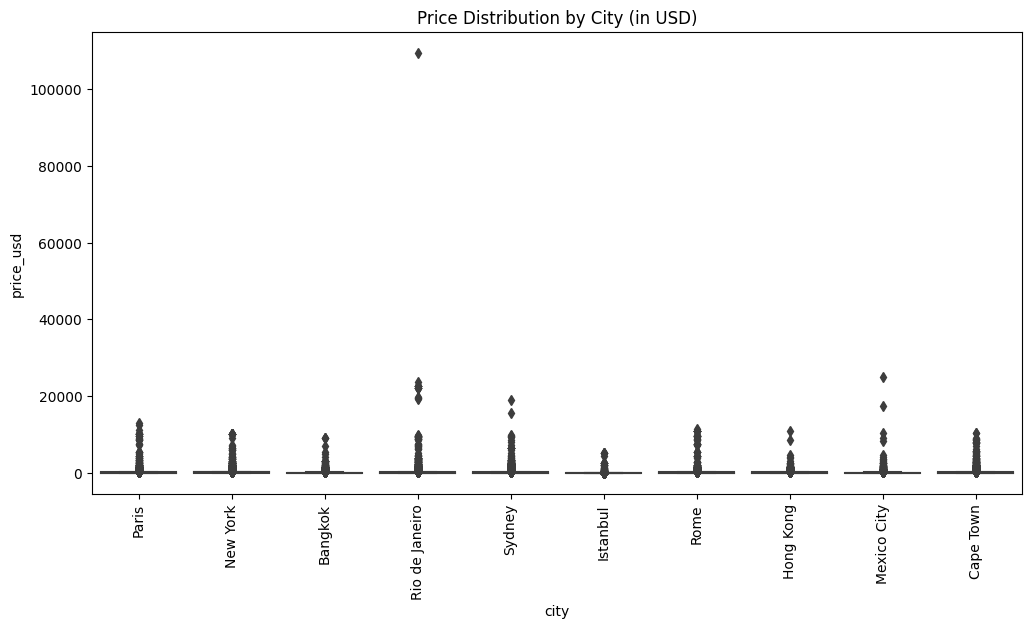

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price_usd', data=df)
plt.xticks(rotation=90)
plt.title('Price Distribution by City (in USD)')
plt.show()

**1. Check the city which offer great value for price**

In [42]:
city_metrics = df.groupby('city').agg({
    'price_usd': 'mean',
    'review_scores_rating': 'mean',
}).rename(columns={'price_usd': 'avg_price', 'review_scores_rating': 'avg_rating'})


In [43]:
city_metrics['value_score'] = city_metrics['avg_rating'] / city_metrics['avg_price']


In [44]:
city_metrics_sorted = city_metrics.sort_values(by='value_score', ascending=False)
print(city_metrics_sorted)

                 avg_price  avg_rating  value_score
city                                               
Istanbul         15.444166   91.063496     5.896304
Mexico City      57.462651   94.837959     1.650428
Bangkok          62.348341   93.001699     1.491647
Hong Kong        97.002086   89.707517     0.924800
Rome            113.516254   93.516489     0.823816
Paris           122.144160   93.063931     0.761919
Rio de Janeiro  129.953119   94.571349     0.727734
Cape Town       137.091860   94.404838     0.688625
New York        142.842240   93.767188     0.656439
Sydney          146.528871   93.234135     0.636285


In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
city_metrics_sorted['value_score'].plot(kind='bar', color='skyblue')
plt.title('Value Score by City')
plt.ylabel('Value Score')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.show()

According to the value score, Istanbul offers a better value for price.

**2. Checking the trend on the number of bookings**

In [46]:
reviews= pd.read_csv('/kaggle/input/airbnb-listings-reviews/Airbnb Data/Reviews.csv', encoding='unicode_escape', low_memory=False)


In [7]:
reviews.head()

listing_id  review_id        date  reviewer_id
0       11798  330265172  2018-09-30     11863072
1       15383  330103585  2018-09-30     39147453
2       16455  329985788  2018-09-30      1125378
3       17919  330016899  2018-09-30    172717984
4       26827  329995638  2018-09-30     17542859

In [47]:
reviews['date'] = pd.to_datetime(reviews['date'])


In [48]:
df = pd.merge(df, reviews[['listing_id', 'date']], on='listing_id', how='left')

In [49]:
df['date'].value_counts().sort_values(ascending=False)

date
2020-01-02    10136
2020-01-01     9635
2019-10-06     9423
2019-11-03     8937
2019-09-29     8905
              ...  
2009-12-29        1
2011-01-20        1
2010-05-10        1
2010-05-19        1
2010-06-03        1
Name: count, Length: 4103, dtype: int64

In [50]:
reviews['month'] = reviews['date'].dt.month
reviews['year'] = reviews['date'].dt.year

In [51]:
monthly_bookings = reviews.groupby(['year', 'month']).size().reset_index(name='bookings_count')
monthly_bookings_recent = monthly_bookings[monthly_bookings['year'].isin([2017,2018, 2019, 2020, 2021])]

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_bookings_recent, x='month', y='bookings_count', hue='year', palette='viridis')
plt.title('Monthly Booking Records')
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.legend(title='Year')
plt.show()


In the last 5 years, most booking were in 2019. 2020 and 2021 showed a drastic reduction in bookings which can be due to COVID restrictions. in 2019, highest bookings were in winter months like Sept, October and Nov

**3. Check the factors which most influence the price**

In [53]:
features = ['room_type', 'bedrooms', 
            'review_scores_rating','city']
target = 'price_usd'  # assuming prices are in USD for consistency
df = df[features + [target]]

In [54]:
df_encoded = pd.get_dummies(df, columns=['room_type', 'city'], drop_first=True)

In [55]:
df_encoded.dropna(inplace=True)


In [56]:
correlation_matrix = df_encoded.corr()
print(correlation_matrix['price_usd'].sort_values(ascending=False))

price_usd                 1.000000
bedrooms                  0.133191
city_Paris                0.067105
city_Sydney               0.054722
city_New York             0.050730
review_scores_rating      0.016934
city_Hong Kong           -0.005767
room_type_Hotel room     -0.007953
city_Cape Town           -0.011067
room_type_Shared room    -0.015738
city_Rome                -0.016717
city_Rio de Janeiro      -0.041070
city_Mexico City         -0.066050
city_Istanbul            -0.071093
room_type_Private room   -0.077761
Name: price_usd, dtype: float64


In [57]:
X = df_encoded.drop(columns=['price_usd'])
y = df_encoded['price_usd']

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Get feature coefficients
feature_importance = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)
print(feature_importance)


                        Coefficient
city_New York             75.540007
city_Sydney               74.860757
city_Paris                67.221922
city_Hong Kong            45.093148
city_Rome                 27.284886
bedrooms                  27.177892
city_Cape Town            11.012439
review_scores_rating       1.223642
room_type_Hotel room      -6.645671
city_Rio de Janeiro       -7.442056
city_Mexico City         -13.508689
room_type_Private room   -37.247331
room_type_Shared room    -47.882761
city_Istanbul            -50.504147


Key Insights:
City Influence on Price:

Cities with high positive coefficients, like New York (+75.54), Sydney (+74.86), and Paris (+67.22), are associated with significantly higher prices compared to a baseline (often the city not shown due to one-hot encoding). This suggests these are high-cost Airbnb markets.
Conversely, cities like Istanbul (-50.50), Mexico City (-13.51), and Rio de Janeiro (-7.44) have negative coefficients, indicating that listings in these cities tend to be more affordable.
Room Type Influence on Price:

Room types like Hotel room (-6.65), Private room (-37.25), and Shared room (-47.88) have negative coefficients compared to the baseline room type (likely Entire home/apartment). This suggests that entire homes are generally the most expensive, while shared and private rooms are cheaper options.
Number of Bedrooms:

The positive coefficient for bedrooms (+27.18) indicates that listings with more bedrooms are associated with higher prices, as expected. This is likely due to the increased capacity and amenities that larger properties offer.
Review Scores Rating:

The coefficient for review_scores_rating (+1.22) is relatively small but positive, suggesting that higher-rated properties are slightly more expensive. However, the influence of ratings on price is minimal compared to city and room type, implying that location and property type are more impactful price determinants.
Interpretation:
Overall, city location and room type have the most substantial impact on Airbnb pricing. Listings in high-demand, high-cost cities (like New York and Sydney) and entire homes tend to have the highest prices. Meanwhile, cities with lower costs of living or less tourist demand (like Istanbul and Mexico City) and shared rooms have lower prices. Attributes like the number of bedrooms also play a role, while review scores have a comparatively minor impact on pricing.






